In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('nba_elo.csv')

In [3]:
carm_df = df[~np.isnan(df['carmelo_prob1'])]
carm_df.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'carm-elo1_pre', 'carm-elo2_pre', 'carm-elo1_post', 'carm-elo2_post',
       'carm-elo_prob1', 'carm-elo_prob2', 'carmelo1_pre', 'carmelo2_pre',
       'carmelo_prob1', 'carmelo_prob2', 'score1', 'score2'],
      dtype='object')

In [4]:
df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,carm-elo1_post,carm-elo2_post,carm-elo_prob1,carm-elo_prob2,carmelo1_pre,carmelo2_pre,carmelo_prob1,carmelo_prob2,score1,score2
0,1946-11-01,1947,0,NaN,TRH,NYK,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,68.0
1,1946-11-02,1947,0,NaN,CHS,NYK,1300.0,1306.7233,0.631101,0.368899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,47.0
2,1946-11-02,1947,0,NaN,PRO,BOS,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,53.0
3,1946-11-02,1947,0,NaN,STB,PIT,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,51.0
4,1946-11-02,1947,0,NaN,DTF,WSC,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,50.0


# Replicating 538's Elo Model

In [5]:
def get_post_elo(home_team, home_team_elo, away_team, away_team_elo, mov):
    
    home_post_elo = get_k(mov, home_team_elo, away_team_elo)*(int(mov>0) - get_win_prob(home_team_elo, away_team_elo)) + home_team_elo
    away_post_elo = away_team_elo + (home_team_elo - home_post_elo)
    
    return home_post_elo, away_post_elo
    
def get_win_prob(home_team_elo, away_team_elo):
    home_team_elo += 100
    return 1.0/(1.0+(10.0**((away_team_elo-home_team_elo)/400)))

def get_k(mov, team_elo, opp_elo):
    
    if mov > 0: elo_dif = team_elo-opp_elo
    else: elo_dif = opp_elo-team_elo
    
    K = 20.0*((np.abs(mov)+3.0)**.8)
    K = K/(7.5 + .006*elo_dif)
    return K

In [10]:
# Use the Dude's Code to Get Elo Values for 2017 season

season_2017 = df[df['season']==2017]

elo_dict = {}

for i in range(season_2017.shape[0]):
    row = season_2017.iloc[i]
    
    team = row.team1
    opp = row.team2
    team_elo = row['elo1_pre']
    opp_elo= row['elo2_pre']
    mov = row.score1 - row.score2
    
    if team not in elo_dict.keys(): elo_dict[team] = team_elo
    if opp not in elo_dict.keys(): elo_dict[opp] = opp_elo
        
    elo_dict[team], elo_dict[opp] = get_post_elo(team, elo_dict[team], opp, elo_dict[opp], mov)

In [11]:
# Get Final Elos from 2017 season

elos_538 = {}

for i in range(season_2017.shape[0]-1, -1, -1):
    
    row = season_2017.iloc[i]
    
    team = row.team1
    opp = row.team2
    team_elo = row['elo1_post']
    opp_elo= row['elo2_post']
    mov = row.score1 - row.score2
    
    if team not in elos_538.keys(): elos_538[team] = team_elo
    if opp not in elos_538.keys(): elos_538[opp] = opp_elo
        
    if len(elos_538.keys()) == 30: break

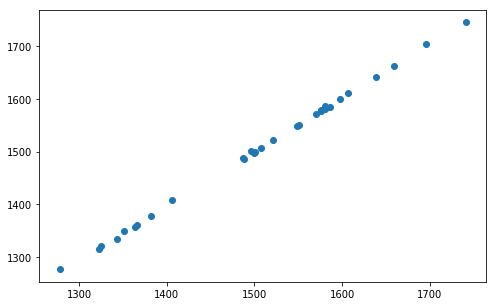

In [30]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

my_list = []
nate_list = []
for team in elo_dict.keys():
    my_list.append(elo_dict[team])
    nate_list.append(elos_538[team])
    
ax.scatter(my_list, nate_list)
plt.show()

# Get Predictions and Accuracy for 2017 Season

In [13]:
preds = []
outcomes = []

# For each game in 2017 season
for i in range(season_2017.shape[0]):
    
    # Get game info
    row = season_2017.iloc[i]   
    team_elo = row['elo1_pre']
    opp_elo= row['elo2_pre']
    mov = row.score1 - row.score2
    
    # Get game prediction, based on pre-game elos
    preds.append(get_win_prob(team_elo, opp_elo) > .5)
    
    # Get game outcome
    outcomes.append(mov > 0)

    # Get list of prediction successes and failures
success_list = [preds[j] == outcomes[j] for j in range(len(preds))]

# Print Accuracy
print(np.mean(success_list))

0.647058823529


# Try Using a K Decay to Predict Outcomes

In [14]:
def my_get_post_elo(home_team, home_team_elo, away_team, away_team_elo, mov, decay):
    
    home_post_elo = my_get_k(mov, home_team_elo, away_team_elo, decay)*(int(mov>0) - my_get_win_prob(home_team_elo, away_team_elo)) + home_team_elo
    away_post_elo = away_team_elo + (home_team_elo - home_post_elo)
    
    return home_post_elo, away_post_elo
    
def my_get_win_prob(home_team_elo, away_team_elo):
    home_team_elo += 100
    return 1.0/(1.0+(10.0**((away_team_elo-home_team_elo)/400)))

def my_get_k(mov, team_elo, opp_elo, decay):
    
    if mov > 0: elo_dif = team_elo-opp_elo
    else: elo_dif = opp_elo-team_elo
    
    K = 20.0*((np.abs(mov)+3.0)**.8)
    K = K/(7.5 + .006*elo_dif)
    return K*decay

In [18]:
elo_dict = {}
epsilon = 1.0
decay = 1.0

dict_list = []

# For each game in the 2017 season
for i in range(season_2017.shape[0]):
    
    # Get game info
    row = season_2017.iloc[i]
    team = row.team1
    opp = row.team2
    mov = row.score1 - row.score2
    
    # If team's first game, use 538's elo to start
    if team not in elo_dict.keys():
        elo_dict[team] = row['elo1_pre']
            
    if opp not in elo_dict.keys():
        elo_dict[opp] = row['elo2_pre']
        
    # Get pre-game ELO estimates
    team_pre = elo_dict[team]
    opp_pre = elo_dict[opp]
        
        
    if i % 100 == 0:
        decay = decay**2
        
    # Update ELOs based on game results    
    elo_dict[team], elo_dict[opp] = my_get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon)
    
    # Build DataFrame with new post-predictions
    team_post = elo_dict[team]
    opp_post = elo_dict[opp]
    
    dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})
    
decay_df = pd.DataFrame(dict_list)

# Test Decaying K Model

Note: There is still a difference when epsilon = 1 because of rounding errors (actually helps the model lol). With the rounding errors, only 13 games are predicted differently

In [19]:
preds = []
outcomes = []

for i in range(decay_df.shape[0]):
    
    row = decay_df.iloc[i]
    
    team_elo = row['team1_pre']
    opp_elo= row['team2_pre']
    mov = row['MOV']
    
    preds.append(my_get_win_prob(team_elo, opp_elo) > .5)
    outcomes.append(mov > 0)

my_success_list = [preds[j] == outcomes[j] for j in range(len(preds))]

# Print Accuracy
print(np.mean(my_success_list))

0.649350649351


In [20]:
elo_dict

{'ATL': 1481.3061384881987,
 'BOS': 1541.5063121909923,
 'BRK': 1368.8525455940191,
 'CHI': 1494.1656327354849,
 'CHO': 1462.9779350845608,
 'CLE': 1690.2416958389308,
 'DAL': 1419.6760287598718,
 'DEN': 1553.3902085217837,
 'DET': 1436.8724262791025,
 'GSW': 1836.9812647118983,
 'HOU': 1597.9246588865985,
 'IND': 1505.8682001442171,
 'LAC': 1617.5798964805356,
 'LAL': 1368.7516705349349,
 'MEM': 1489.2367616847068,
 'MIA': 1570.4937856587933,
 'MIL': 1507.1168528173318,
 'MIN': 1461.5685946599162,
 'NOP': 1484.8684430901715,
 'NYK': 1376.6566382878716,
 'OKC': 1521.2478118937508,
 'ORL': 1355.6226581538738,
 'PHI': 1343.006288565862,
 'PHO': 1345.8162437287274,
 'POR': 1539.4361811249241,
 'SAC': 1397.7948848700137,
 'SAS': 1652.2165783605158,
 'TOR': 1539.6006889204723,
 'UTA': 1600.7418406982547,
 'WAS': 1580.7019832336853}

In [21]:
decay_df.head()

,MOV,team1,team1_post,team1_pre,team2,team2_post,team2_pre
0,29.0,CLE,1699.018479,1695.521828,NYK,1411.049199,1414.545850
1,9.0,POR,1590.066912,1584.628972,UTA,1524.883456,1530.321395
2,-29.0,GSW,1665.850942,1692.979250,SAS,1722.418181,1695.289874
3,9.0,IND,1539.220778,1533.109375,DAL,1497.181912,1503.293315
4,-12.0,ORL,1444.077783,1454.079100,MIA,1584.217603,1574.216287


In [22]:
season_2017.head()['elo1_post']

64473    1698.804089
64474    1589.679679
64475    1663.496689
64476    1538.777864
64477    1443.290363
Name: elo1_post, dtype: float64

In [23]:
# Number of rounding error
len(success_list) - np.sum([success_list[i] == my_success_list[i] for i in range(len(success_list))])

13

# Incorporate 538's Seasonal ELO Adjustments

In [24]:
# Just 2017 and 2018 seasons
seasons = df[df['season']>=2017]
seasons = seasons[seasons['season']<2019]

# Get Final ELOs at the end of 2018
elos_538 = {}

for i in range(seasons.shape[0]-1, -1, -1):
    
    row = seasons.iloc[i]
    
    team = row.team1
    opp = row.team2
    team_elo = row['elo1_post']
    opp_elo= row['elo2_post']
    mov = row.score1 - row.score2
    
    if team not in elos_538.keys(): elos_538[team] = team_elo
    if opp not in elos_538.keys(): elos_538[opp] = opp_elo
        
    if len(elos_538.keys()) == 30: break
        
# Get my ELOs, replicating 538's model

elo_dict = {}
epsilon = 1.0

dict_list = []

# For each game in the 2017 season
for i in range(seasons.shape[0]):
    
    # Get game info
    row = seasons.iloc[i]
    team = row.team1
    opp = row.team2
    mov = row.score1 - row.score2
    
    ############
    # Seasonal Adjustment for every team
    ############
    if i > 0 and row.season != seasons.iloc[i-1].season:
        for k in elo_dict.keys():
            elo_dict[k] = .75*elo_dict[k] + .25*1505
    
    # If team's first game, use 538's elo to start
    if team not in elo_dict.keys():
        elo_dict[team] = row['elo1_pre']
            
    if opp not in elo_dict.keys():
        elo_dict[opp] = row['elo2_pre']
        
    # Get pre-game ELO estimates
    team_pre = elo_dict[team]
    opp_pre = elo_dict[opp]
        
        
    if i % 100 == 0:
        decay = decay**2
        
    # Update ELOs based on game results    
    elo_dict[team], elo_dict[opp] = my_get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon)
    
    # Build DataFrame with new post-predictions
    team_post = elo_dict[team]
    opp_post = elo_dict[opp]
    
    dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})
    
test_df= pd.DataFrame(dict_list)

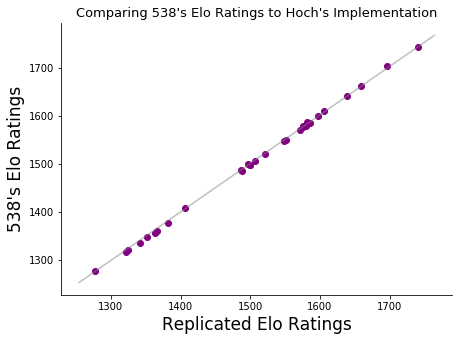

In [47]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

my_list = []
nate_list = []
for team in elo_dict.keys():
    my_list.append(elo_dict[team])
    nate_list.append(elos_538[team])
    
ax.scatter(my_list, nate_list, color='purple')
ax.plot(ax.get_xlim(), ax.get_ylim(), color='grey', alpha=.5)

ax.set_xlabel('Replicated Elo Ratings', fontsize=17)
ax.set_ylabel("538's Elo Ratings", fontsize=17)
ax.set_title("Comparing 538's Elo Ratings to Hoch's Implementation", fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('Hoch_Comparison.png')
plt.show()

In [34]:
df[~np.isnan(df['carm-elo1_post'])]

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,carm-elo1_post,carm-elo2_post,carm-elo_prob1,carm-elo_prob2,carmelo1_pre,carmelo2_pre,carmelo_prob1,carmelo_prob2,score1,score2
63157,2015-10-27,2016,0,NaN,ATL,DET,1561.843550,1472.058800,0.748850,0.251150,...,1521.809995,1472.682265,0.752780,0.247220,NaN,NaN,NaN,NaN,94.0,106.0
63158,2015-10-27,2016,0,NaN,CHI,CLE,1569.533975,1645.314425,0.534798,0.465202,...,1570.473937,1725.924036,0.403078,0.596922,NaN,NaN,NaN,NaN,97.0,95.0
63159,2015-10-27,2016,0,NaN,GSW,NOP,1742.966075,1521.178175,0.864404,0.135596,...,1734.342589,1551.298021,0.822577,0.177423,NaN,NaN,NaN,NaN,111.0,95.0
63160,2015-10-28,2016,0,NaN,ORL,WAS,1360.168625,1535.828375,0.392806,0.607194,...,1442.238910,1502.448982,0.559331,0.440669,NaN,NaN,NaN,NaN,87.0,88.0
63161,2015-10-28,2016,0,NaN,MIA,CHO,1468.145075,1426.797875,0.692889,0.307111,...,1467.794484,1469.154570,0.609179,0.390821,NaN,NaN,NaN,NaN,104.0,94.0
63162,2015-10-28,2016,0,NaN,TOR,IND,1501.545425,1504.903475,0.635600,0.364400,...,1530.324875,1461.085883,0.712967,0.287033,NaN,NaN,NaN,NaN,106.0,99.0
63163,2015-10-28,2016,0,NaN,DET,UTA,1492.605998,1542.714050,0.571311,0.428689,...,1479.957346,1534.460152,0.483733,0.516267,NaN,NaN,NaN,NaN,92.0,87.0
63164,2015-10-28,2016,0,NaN,BOS,PHI,1519.678625,1333.391825,0.838620,0.161380,...,1575.320376,1292.293003,0.894997,0.105003,NaN,NaN,NaN,NaN,112.0,95.0
63165,2015-10-28,2016,0,NaN,BRK,CHI,1469.552900,1573.944108,0.493681,0.506319,...,1280.996484,1577.993946,0.310278,0.689722,NaN,NaN,NaN,NaN,100.0,115.0
63166,2015-10-28,2016,0,NaN,OKC,SAS,1563.671375,1666.972550,0.495249,0.504751,...,1695.169663,1680.087801,0.654833,0.345167,NaN,NaN,NaN,NaN,112.0,106.0


# Worry about carm-elo/carmelo later

## Time to Generalize This Shit
--------------------
Epsilon Model will be trained on seasons 2010 - 2016, tested on 2017 - 2018

In [307]:
# Get Just Seasons 2010 and on
games = df[df['season'] >= 2010]
games = games[games['season'] < 2019]

In [311]:
# Hyperparameters to Tune
season_start_epsilons = [.8, .9, .95, .98, 1.0, 1.02, 1.05, 1.1, 1.2]
epsilon_decays = [.6, .7, .8, .9, .95, .98, 1.0, 1.02, 1.05, 1.1, 1.2]

In [320]:
# Get Decay ELOs

TEST_START_YEAR = 2017

results_dict_list = []

# For Each Combination of start_epsilon and epsilon_decay
for season_start_epsilon in season_start_epsilons:
    for epsilon_decay in epsilon_decays:
    
        epsilon = season_start_epsilon

        elo_dict = {}

        dict_list = []

        # For Each Game
        for i in range(games.shape[0]):

            # Get Game Info
            row = games.iloc[i]
            team = row.team1
            opp = row.team2
            mov = row.score1 - row.score2

            # Seasonal ELO Adjustment for Every Team
            if i > 0 and row.season != games.iloc[i-1].season:
                for k in elo_dict.keys():
                    elo_dict[k] = .75*elo_dict[k] + .25*1505
                    
                # Reset Epsilon
                epsilon = season_start_epsilon

            # If team's first game, use 538's elo to start
            if team not in elo_dict.keys():
                elo_dict[team] = row['elo1_pre']

            if opp not in elo_dict.keys():
                elo_dict[opp] = row['elo2_pre']

            # Get Pre-Game ELO Estimates
            team_pre = elo_dict[team]
            opp_pre = elo_dict[opp]

            # Adjust Epsilon
            if i % 100 == 0:
                epsilon *= epsilon_decay

            # Update ELOs based on game results    
            elo_dict[team], elo_dict[opp] = my_get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon)

            if row.season >= TEST_START_YEAR:

                # Build DataFrame with new post-predictions
                team_post = elo_dict[team]
                opp_post = elo_dict[opp]

                dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})

        test_df= pd.DataFrame(dict_list)
        
        
        preds = []
        outcomes = []
        
        # Get My Model's Results
        for i in range(test_df.shape[0]):

            # Get Game Info
            row = test_df.iloc[i]
            mov = row.MOV 
            my_team_elo = row['team1_pre']
            my_opp_elo = row['team2_pre']

            preds.append(get_win_prob(my_team_elo, my_opp_elo) > .5)
            outcomes.append(mov > 0)

        my_success_list = [preds[j] == outcomes[j] for j in range(len(preds))]
            
        # Start Building Nice Results DataFrame
        results_dict_list.append({'accuracy': np.mean(my_success_list), 'season_start_ep': season_start_epsilon, 'epsilon_decay': epsilon_decay})
results_df = pd.DataFrame(results_dict_list)

In [342]:
# Get 538's Elo Model's Results

nate_test_df = games[games['season']>=TEST_START_YEAR]
nate_test_df = nate_test_df[nate_test_df['season']<2019]


preds = []
outcomes = []
carm_preds = []

# For Each Game
for i in range(nate_test_df.shape[0]):

    # Get Game Info
    row = nate_test_df.iloc[i]
    mov = row.score1 - row.score2   
    nate_team_elo = row['elo1_pre']
    nate_opp_elo = row['elo2_pre']
    nate_team_carmelo = row['carm-elo1_pre']
    nate_opp_carmelo = row['carm-elo2_pre']
    
    preds.append(get_win_prob(nate_team_elo, nate_opp_elo) > .5)
    carm_preds.append(get_win_prob(nate_team_carmelo, nate_opp_carmelo) > .5)
    
    outcomes.append(mov > 0)
    
nate_success_list = [preds[j] == outcomes[j] for j in range(len(preds))]
nate_carm_success_list = [carm_preds[j] == outcomes[j] for j in range(len(carm_preds))]
    
# Print Overall Successes
print("538's ELO Accuracy: ", np.mean(nate_success_list))
print("538's CARM-ELO Accuracy: ", np.mean(nate_carm_success_list))
print("Best Tuned Decay ELO Accuracy: ", np.max(results_df['accuracy']))

538's ELO Accuracy:  0.65623807707
538's CARM-ELO Accuracy:  0.656619610836
Best Tuned Decay ELO Accuracy:  0.659290347196


In [341]:
results_df.loc[np.argmax(results_df['accuracy'])]

C:\Users\ejohn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


accuracy           0.65929
epsilon_decay      0.98000
season_start_ep    1.10000
Name: 82, dtype: float64

In [336]:
# Re-Fit Best Model, Make DataFrame of Predictions

best_season_start_epsilon = results_df.loc[np.argmax(results_df['accuracy'])].season_start_ep
best_epsilon_decay = results_df.loc[np.argmax(results_df['accuracy'])].epsilon_decay

epsilon = best_season_start_epsilon

elo_dict = {}
dict_list = []

# For Each Game
for i in range(games.shape[0]):

    # Get Game Info
    row = games.iloc[i]
    team = row.team1
    opp = row.team2
    mov = row.score1 - row.score2

    # Seasonal ELO Adjustment for Every Team
    if i > 0 and row.season != games.iloc[i-1].season:
        for k in elo_dict.keys():
            elo_dict[k] = .75*elo_dict[k] + .25*1505

        # Reset Epsilon
        epsilon = best_season_start_epsilon

    # If team's first game, use 538's elo to start
    if team not in elo_dict.keys():
        elo_dict[team] = row['elo1_pre']

    if opp not in elo_dict.keys():
        elo_dict[opp] = row['elo2_pre']

    # Get Pre-Game ELO Estimates
    team_pre = elo_dict[team]
    opp_pre = elo_dict[opp]

    # Adjust Epsilon
    if i % 100 == 0:
        epsilon *= best_epsilon_decay

    # Update ELOs based on game results    
    elo_dict[team], elo_dict[opp] = my_get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon)

    if row.season >= TEST_START_YEAR:

        # Build DataFrame with new post-predictions
        team_post = elo_dict[team]
        opp_post = elo_dict[opp]

        dict_list.append({'season': row.season, 'date': row.date, 'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})

best_test_df= pd.DataFrame(dict_list)
best_test_df.head()

C:\Users\ejohn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


,MOV,date,season,team1,team1_post,team1_pre,team2,team2_post,team2_pre
0,29.0,2016-10-25,2017,CLE,1685.206306,1680.919972,NYK,1414.309878,1418.596212
1,9.0,2016-10-25,2017,POR,1584.843556,1578.724322,UTA,1523.002266,1529.121500
2,-29.0,2016-10-25,2017,GSW,1657.970290,1687.753444,SAS,1720.520104,1690.736950
3,9.0,2016-10-26,2017,IND,1540.414968,1533.740672,DAL,1495.715400,1502.389696
4,-12.0,2016-10-26,2017,ORL,1442.983475,1454.214281,MIA,1580.085072,1568.854266


In [344]:
# Test Best Model by Year ###### NOT DONE YET

# Get 538's Elo Model's Results

nate_test_df = games[games['season']>=TEST_START_YEAR]
nate_test_df = nate_test_df[nate_test_df['season']<2019]

preds_2017 = []
preds_2018 = []
outcomes_2017 = []
outcomes_2018 = []
carm_preds_2017 = []
carm_preds_2018 = []
my_preds_2017 = []
my_preds_2018 = []

# For Each Game
for i in range(nate_test_df.shape[0]):

    # Get Game Info
    row = nate_test_df.iloc[i]
    mov = row.score1 - row.score2  
    s = row.season
    
    nate_team_elo = row['elo1_pre']
    nate_opp_elo = row['elo2_pre']
    nate_team_carmelo = row['carm-elo1_pre']
    nate_opp_carmelo = row['carm-elo2_pre']
    
    my_row = best_test_df.iloc[i]
    my_team_elo = my_row['team1_pre']
    my_opp_elo = my_row['team2_pre']
    
    # Get Predictions and Outcomes
    if s == 2017:
        preds_2017.append(get_win_prob(nate_team_elo, nate_opp_elo) > .5)
        carm_preds_2017.append(get_win_prob(nate_team_carmelo, nate_opp_carmelo) > .5)
        my_preds_2017.append(get_win_prob(my_team_elo, my_opp_elo) > .5)
    
        outcomes_2017.append(mov > 0)
        
    if s == 2018:
        preds_2018.append(get_win_prob(nate_team_elo, nate_opp_elo) > .5)
        carm_preds_2018.append(get_win_prob(nate_team_carmelo, nate_opp_carmelo) > .5)
        my_preds_2018.append(get_win_prob(my_team_elo, my_opp_elo) > .5)
    
        outcomes_2018.append(mov > 0)
    
nate_success_list_2017 = [preds_2017[j] == outcomes_2017[j] for j in range(len(preds_2017))]
nate_carm_success_list_2017 = [carm_preds_2017[j] == outcomes_2017[j] for j in range(len(carm_preds_2017))]
nate_success_list_2018 = [preds_2018[j] == outcomes_2018[j] for j in range(len(preds_2018))]
nate_carm_success_list_2018 = [carm_preds_2018[j] == outcomes_2018[j] for j in range(len(carm_preds_2018))]
my_success_list_2017 = [my_preds_2017[j] == outcomes_2017[j] for j in range(len(preds_2017))]
my_success_list_2018 = [my_preds_2018[j] == outcomes_2018[j] for j in range(len(carm_preds_2018))]
    
# Print Overall Successes
print('2017:')
print("538's ELO Accuracy: ", np.mean(nate_success_list_2017))
print("538's CARM-ELO Accuracy: ", np.mean(nate_carm_success_list_2017))
print("Best Tuned Decay ELO Accuracy: ", np.mean(my_success_list_2017))
print("")
print('2018')
print("538's ELO Accuracy: ", np.mean(nate_success_list_2018))
print("538's CARM-ELO Accuracy: ", np.mean(nate_carm_success_list_2018))
print("Best Tuned Decay ELO Accuracy: ", np.mean(my_success_list_2018))

2017:
538's ELO Accuracy:  0.647058823529
538's CARM-ELO Accuracy:  0.651642475172
Best Tuned Decay ELO Accuracy:  0.649350649351

2018
538's ELO Accuracy:  0.665396341463
538's CARM-ELO Accuracy:  0.661585365854
Best Tuned Decay ELO Accuracy:  0.669207317073


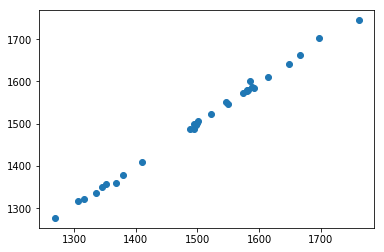

In [346]:
# Make Sure Methods Are Right - Re-fit Model with parameters 1.0 amd 1.0

epsilon = 1.0
epsilon_decay = 1.0

elo_dict = {}

dict_list = []

# For Each Game
for i in range(games.shape[0]):

    # Get Game Info
    row = games.iloc[i]
    team = row.team1
    opp = row.team2
    mov = row.score1 - row.score2

    # Seasonal ELO Adjustment for Every Team
    if i > 0 and row.season != games.iloc[i-1].season:
        for k in elo_dict.keys():
            elo_dict[k] = .75*elo_dict[k] + .25*1505

        # Reset Epsilon
        epsilon = season_start_epsilon

    # If team's first game, use 538's elo to start
    if team not in elo_dict.keys():
        elo_dict[team] = row['elo1_pre']

    if opp not in elo_dict.keys():
        elo_dict[opp] = row['elo2_pre']

    # Get Pre-Game ELO Estimates
    team_pre = elo_dict[team]
    opp_pre = elo_dict[opp]

    # Adjust Epsilon
    if i % 100 == 0:
        epsilon *= epsilon_decay

    # Update ELOs based on game results    
    elo_dict[team], elo_dict[opp] = my_get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon)
    
my_list = []
nate_list = []
for team in elo_dict.keys():
    
    if team != 'NJN':
        my_list.append(elo_dict[team])
        nate_list.append(elos_538[team])
    
plt.scatter(my_list, nate_list)
plt.show()